In [1]:
from transformers import AutoModelForCausalLM, AutoTokenizer
import torch

import warnings
warnings.filterwarnings('ignore')

In [2]:
from transformers import AutoModelForCausalLM, AutoTokenizer
import torch

import warnings
warnings.filterwarnings('ignore')

In [3]:
def load_tokenizer_and_model(model="microsoft/DialoGPT-large"):
    """
    Load tokenizer and model instance for some specific Phi-2 model.
    """
    # Initialize tokenizer and model
    print("Loading model...")
    tokenizer = AutoTokenizer.from_pretrained(model, padding_side='left')
    model = AutoModelForCausalLM.from_pretrained(model)
    
    # Return tokenizer and model
    return tokenizer, model

In [4]:
from intel_extension_for_pytorch.quantization import prepare, convert
import intel_extension_for_pytorch as ipex

def quantize_model(tokenizer, model):
    """
    Adding IPEX dynamic quantization to the model
    """
    # Evaluate model
    model.eval()
    
    print("Quantization in progress...")
    
    # Prepare example outputs for the model
    question, text = "What is SYCL?", "SYCL is an industry-driven standard, developed by Kronos Group and announced in March 2014."
    inputs = tokenizer(question, text, return_tensors="pt")
    jit_inputs  = tuple((inputs['input_ids']))
    
    # Create configuration for dynamic quantization
    qconfig = ipex.quantization.default_dynamic_qconfig
    
    # Optimize model
    model = ipex.optimize(model)
    
    # Prepare model for quantization using previously prepared parameters
    prepared_model = prepare(model, qconfig, example_inputs=jit_inputs, inplace=False)
    
    # Convert types in model
    converted_model = convert(prepared_model)
    
    return tokenizer, converted_model

In [5]:
from intel_extension_for_pytorch.quantization import prepare, convert
import intel_extension_for_pytorch as ipex

def quantize_model(tokenizer, model):
    """
    Adding IPEX dynamic quantization to the model
    """
    # Evaluate model
    model.eval()
    
    print("Quantization in progress...")
    
    # Prepare example outputs for the model
    question, text = "What is SYCL?", "SYCL is an industry-driven standard, developed by Kronos Group and announced in March 2014."
    inputs = tokenizer(question, text, return_tensors="pt")
    jit_inputs  = tuple((inputs['input_ids']))
    
    # Create configuration for dynamic quantization
    qconfig = ipex.quantization.default_dynamic_qconfig
    
    # Optimize model
    model = ipex.optimize(model)
    
    # Prepare model for quantization using previously prepared parameters
    prepared_model = prepare(model, qconfig, example_inputs=jit_inputs, inplace=False)
    
    # Convert types in model
    converted_model = convert(prepared_model)
    
    return tokenizer, converted_model

In [6]:
def generate_response(tokenizer, model, chat_round, chat_history_ids):
    """
    Generate a response to some user input.
    """
    # Encode user input and End-of-String (EOS) token
    new_input_ids = tokenizer.encode(input(">> You:") + tokenizer.eos_token, return_tensors='pt')
    
    # Append tokens to chat history
    bot_input_ids = torch.cat([chat_history_ids, new_input_ids], dim=-1) if chat_round > 0 else new_input_ids
    
    # Generate response given maximum chat length history of 2000 tokens
    chat_history_ids = model.generate(
        bot_input_ids,
        do_sample=True, 
        max_length=2000,
        top_k=50, 
        top_p=0.95,
        pad_token_id=tokenizer.eos_token_id
    )
    
    # Print response
    print("Phi-2: {}".format(tokenizer.decode(chat_history_ids[:, bot_input_ids.shape[-1]:][0], skip_special_tokens=True)))
    
    # Return the chat history ids
    return chat_history_ids

In [7]:
def chat_for_n_rounds(tokenizer, model, n=5):
    """
    Chat with chatbot for n rounds (n = 5 by default)
    """

    # Initialize history variable
    chat_history_ids = None

    # Chat for n rounds
    for chat_round in range(n):
        chat_history_ids = generate_response(tokenizer, model, chat_round, chat_history_ids)

In [8]:
# Initialize tokenizer and model
tokenizer, model = load_tokenizer_and_model()

# Adding ipex quantization to the model
tokenizer, model = quantize_model(tokenizer, model)
torch.save(model.state_dict(), './quantized_model')


Loading model...
Quantization in progress...


In [9]:
chat_for_n_rounds(tokenizer, model, 2)

>> You: Hello


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Phi-2: Whats up


>> You: How are you doing?


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Phi-2: Good You?


In [10]:
from time import time
def test_inference(model, data, warmup=5 , iters=25):
    print("Warmup...")
    for i in range(warmup):
        out = model(data)

    print("Inference...")
    inference_time = 0
    for i in range(iters):
        start_time = time()
        out = model(data)
        end_time = time()
        inference_time = inference_time + (end_time - start_time)

    inference_time = inference_time / iters
    return inference_time

In [11]:
print("Inference with FP32")
tokenizer_fp32, model_fp32 = load_tokenizer_and_model()
data = torch.randint(model_fp32.config.vocab_size, size=[1, 512])
fp32_inference_time = test_inference(model_fp32, data = data)

Inference with FP32
Loading model...
Warmup...
Inference...


In [12]:
print("Inference with Dynamic INT8")
tokenizer_int8, model_int8 = load_tokenizer_and_model()
tokenizer_int8, model_int8 = quantize_model(tokenizer_int8, model_int8)
data = torch.randint(model_int8.config.vocab_size, size=[1, 512])
int8_inference_time = test_inference(model_int8, data = data)

Inference with Dynamic INT8
Loading model...
Quantization in progress...
Warmup...
Inference...


<BarContainer object of 2 artists>

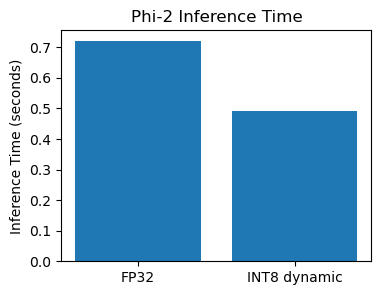

In [13]:
import matplotlib.pyplot as plt

# Create bar chart with training time results
plt.figure(figsize=(4,3))
plt.title("Phi-2 Inference Time")
plt.ylabel("Inference Time (seconds)")
plt.bar(["FP32", "INT8 dynamic"], [fp32_inference_time, int8_inference_time])

In [14]:
print("[CODE_SAMPLE_COMPLETED_SUCCESFULLY]")

[CODE_SAMPLE_COMPLETED_SUCCESFULLY]
